In [1]:

import cv2
import numpy as np
import os
from tqdm import tqdm

# load data
final_data = "C:/Users/HUY/Desktop/my_project/final_data"
synthetic_path = "C:/Users/HUY/Desktop/my_project/synthetic_data"

# tải dữ liệu dựa theo góc của dáng đi
def load_view(folder_paths, view):
    train, test = [], []
    train_view = []
    test_view = []
    for folder in (os.listdir(folder_paths)):
        if folder == "train":
            tr_labels = []
            for img in os.listdir(f"{folder_paths}/{folder}"):
                if view in img:
                    im = np.array(cv2.imread(f"{folder_paths}/{folder}/{img}", cv2.IMREAD_GRAYSCALE))
                    tr_labels.append(img[0:3])
                    train.append(im)
                    train_view.append(view)
        if folder == "test":
            te_labels = []
            for img in os.listdir(f"{folder_paths}/{folder}"):
                if view in img:
                    im = np.array(cv2.imread(f"{folder_paths}/{folder}/{img}", cv2.IMREAD_GRAYSCALE))
                    te_labels.append(img[0:3])
                    test.append(im)
                    test_view.append(view)
    # print(f"Hoàn thành tải dữ liệu lên từ {folder_paths} với góc {view} độ")
    return train, test, tr_labels, te_labels, train_view, test_view


# tải dữ liệu dáng đi với tất cả các góc
def load_data(view = "crossview"):
    
    views = ["000","018","036","054","072","090","108","126","144","162","180"]
    x_train, y_train = [], []
    x_test, y_test = [], []
    train_view, test_view = [], []
    
    if view in views:
        views = [view]
    
    for view in tqdm(views):
        x_rtrain_view, x_rtest_view, y_rtrain_view, y_rtest_view, rtrain_view, rtest_view = load_view(final_data, view)
        x_strain_view, x_stest_view, y_strain_view, y_stest_view, strain_view, stest_view = load_view(synthetic_path, view)
        
        x_train = x_train + x_rtrain_view + x_strain_view
        y_train = y_train + y_rtrain_view + y_strain_view
        x_test = x_test + x_rtest_view + x_stest_view
        y_test = y_test + y_rtest_view + y_stest_view
        train_view = train_view + rtrain_view + strain_view
        test_view = test_view + rtest_view + stest_view
        
    print(f"✅ Kích thước tập train và nhãn: {len(x_train)} và {len(y_train)}")
    print(f"✅ Kích thước tập test và nhãn: {len(x_test)} và {len(y_test)}")
    return x_train, y_train, x_test, y_test, train_view, test_view

x_train, y_train, x_test, y_test, train_view, test_view = load_data(view = "crossview")

100%|██████████| 11/11 [00:05<00:00,  2.18it/s]

✅ Kích thước tập train và nhãn: 11508 và 11508
✅ Kích thước tập test và nhãn: 7672 và 7672


In [2]:
# chuyển nhãn dán dữ thành mã hóa one-hot để đưa vào mô hình CNN
from sklearn.preprocessing import LabelEncoder

def to_categorical(y, num_classes=None):
    y = np.array(y, dtype=int)
    if num_classes is None:
        num_classes = np.max(y) + 1
    one_hot = np.zeros((len(y), num_classes))
    one_hot[np.arange(len(y)), y] = 1
    return one_hot

# One-hot encoding
all_labels = np.concatenate([y_train, y_test])
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

y_train_int = label_encoder.transform(y_train)
y_test_int = label_encoder.transform(y_test)

# one-hot encoding
num_classes = len(label_encoder.classes_)
y_train_encoded = to_categorical(y_train_int, num_classes)
y_test_encoded = to_categorical(y_test_int, num_classes)

# Normailize
x_train = np.array(x_train).astype('float32') / 255.0
x_test = np.array(x_test).astype('float32') / 255.0
# OKE

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential()

# Convolutional layer 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 44, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional layer 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional layer 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten và fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # tránh overfitting
model.add(Dense(24, activation='softmax'))  

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 42, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 62, 42, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 19, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 29, 19, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 9, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 7, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 7, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 391,704 (1.49 MB)

 Trainable params: 391,256 (1.49 MB)

 Non-trainable params: 448 (1.75 KB)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,             
    restore_best_weights=True 
)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Huấn luyện mô hình
history = model.fit(
    x_train, y_train_encoded,
    validation_data=(x_test, y_test_encoded),
    epochs = 30,
    callbacks=[early_stop],
    batch_size=32,
    verbose=1
)

Epoch 1/30
360/360 ━━━━━━━━━━━━━━━━━━━━ 56s 144ms/step - accuracy: 0.0691 - loss: 3.2492 - val_accuracy: 0.0388 - val_loss: 3.5916
Epoch 2/30
360/360 ━━━━━━━━━━━━━━━━━━━━ 53s 148ms/step - accuracy: 0.0970 - loss: 3.0255 - val_accuracy: 0.1199 - val_loss: 2.9206
Epoch 3/30
360/360 ━━━━━━━━━━━━━━━━━━━━ 53s 147ms/step - accuracy: 0.0952 - loss: 2.9894 - val_accuracy: 0.1124 - val_loss: 2.8074
Epoch 4/30
360/360 ━━━━━━━━━━━━━━━━━━━━ 53s 148ms/step - accuracy: 0.0976 - loss: 2.9723 - val_accuracy: 0.1328 - val_loss: 2.7670
Epoch 5/30
360/360 ━━━━━━━━━━━━━━━━━━━━ 59s 163ms/step - accuracy: 0.0956 - loss: 2.9587 - val_accuracy: 0.1762 - val_loss: 2.7286
Epoch 6/30
360/360 ━━━━━━━━━━━━━━━━━━━━ 54s 150ms/step - accuracy: 0.1248 - loss: 2.8352 - val_accuracy: 0.0787 - val_loss: 3.5167
Epoch 7/30
360/360 ━━━━━━━━━━━━━━━━━━━━ 54s 149ms/step - accuracy: 0.1472 - loss: 2.7406 - val_accuracy: 0.2492 - val_loss: 2.4388
Epoch 8/30
360/360 ━━━━━━━━━━━━━━━━━━━━ 53s 146ms/step - accuracy: 0.1964 - loss: 2

In [7]:
# Đánh giá mô hình
test_loss, test_acc = model.evaluate(x_test, y_test_encoded, verbose=0)
print(f"\n✅ Test accuracy: {test_acc:.4f} - Test loss: {test_loss:.4f}")


✅ Test accuracy: 0.9632 - Test loss: 0.1435


conv2d_3 - filter shape: (None, 62, 42, 32)
conv2d_4 - filter shape: (None, 29, 19, 64)
conv2d_5 - filter shape: (None, 12, 7, 128)


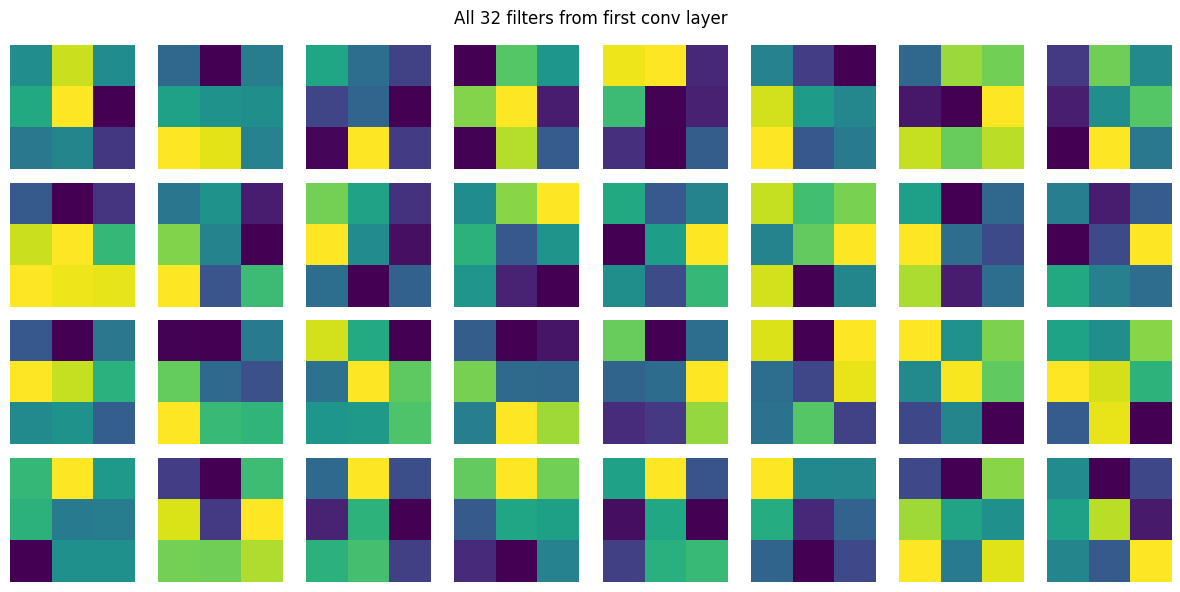

In [17]:
from matplotlib import pyplot as plt

for layer in model.layers:
    if 'conv' not in layer.name:
        continue

    print(f"{layer.name} - filter shape: {layer.output.shape}")

filters, _ = model.layers[0].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# In tất cả 32 filters (vì chỉ có 1 channel, ta lấy [:,:,0,i])
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(filters[:, :, 0, i])
    ax.axis('off')
plt.suptitle("All 32 filters from first conv layer")
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


c:\Users\HUY\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_92']
Received: inputs=Tensor(shape=(1, 64, 44))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


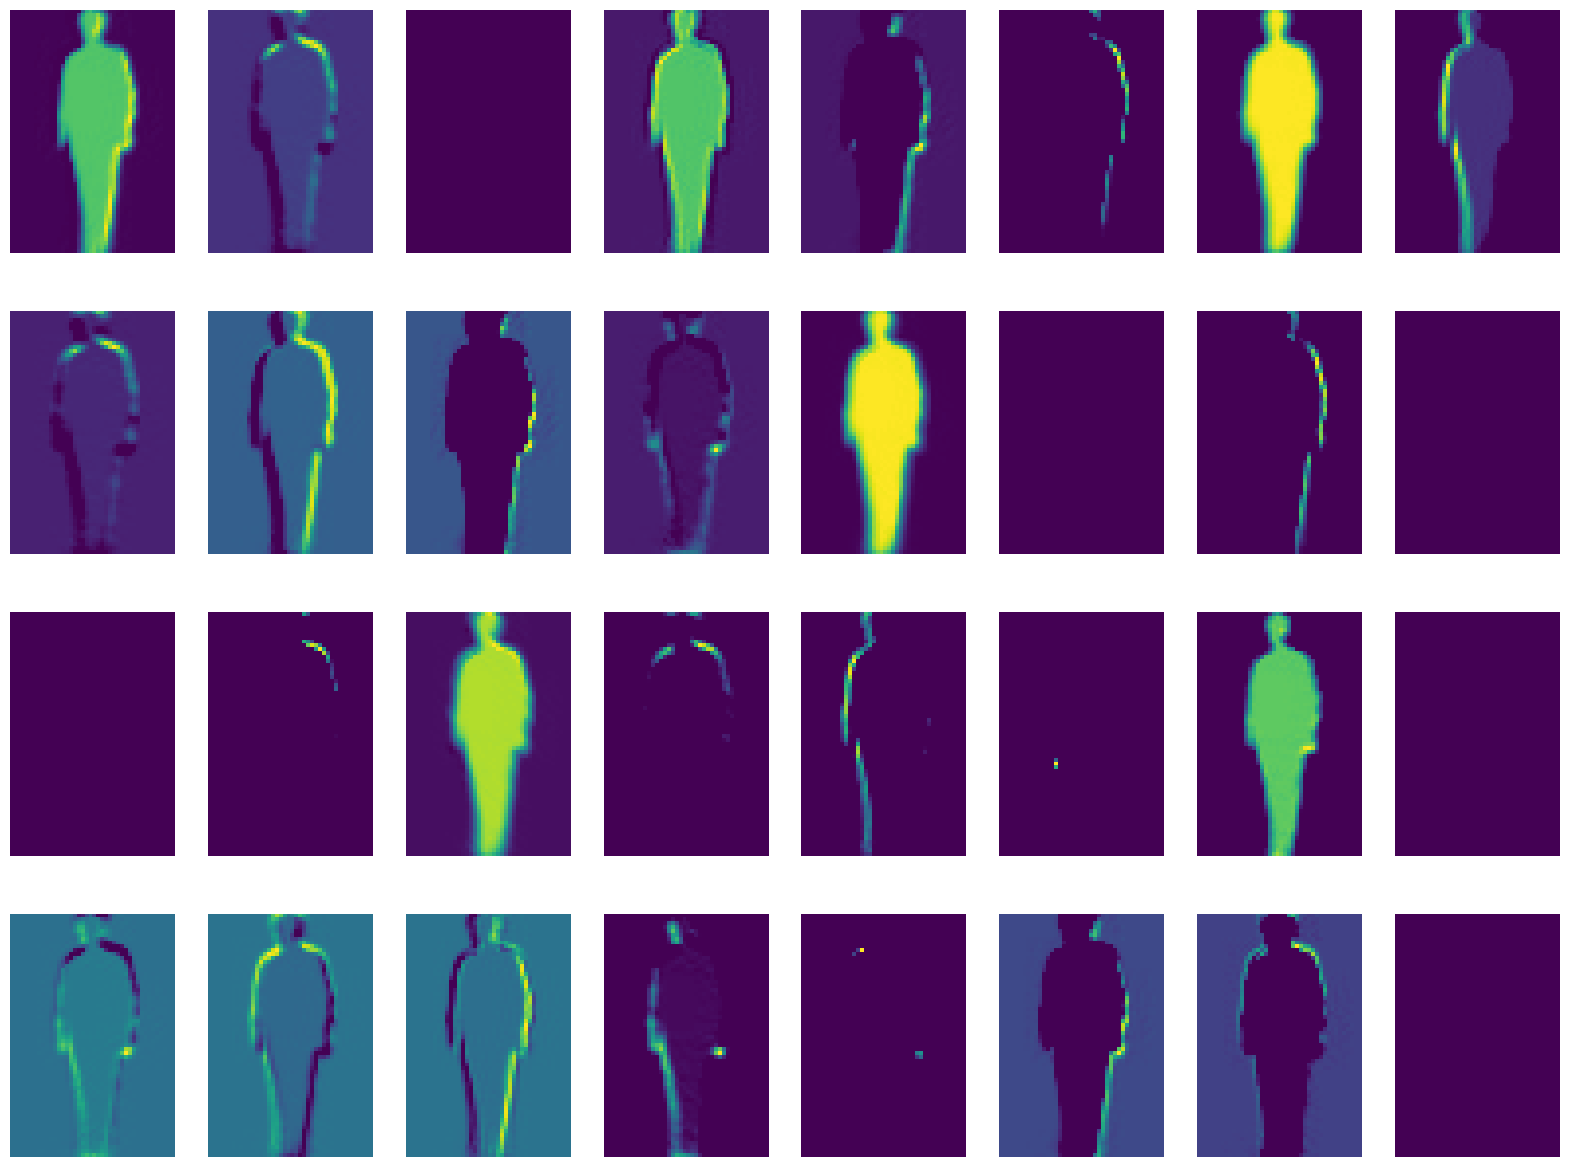

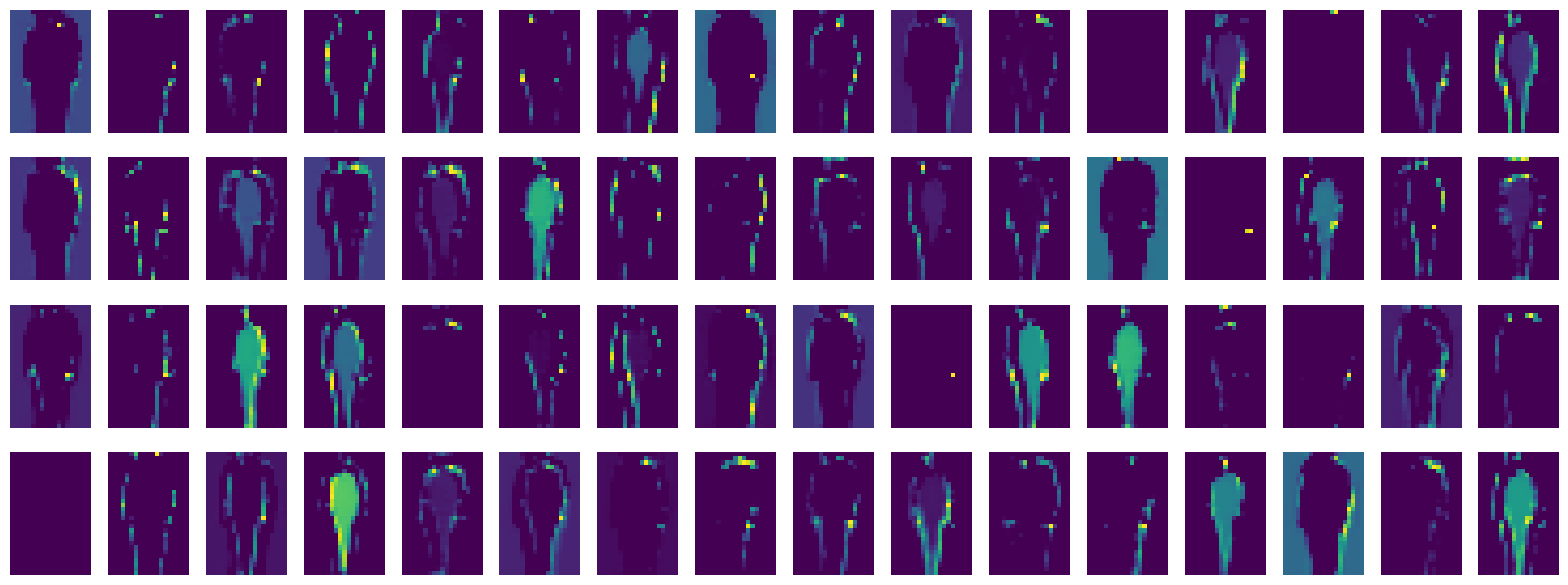

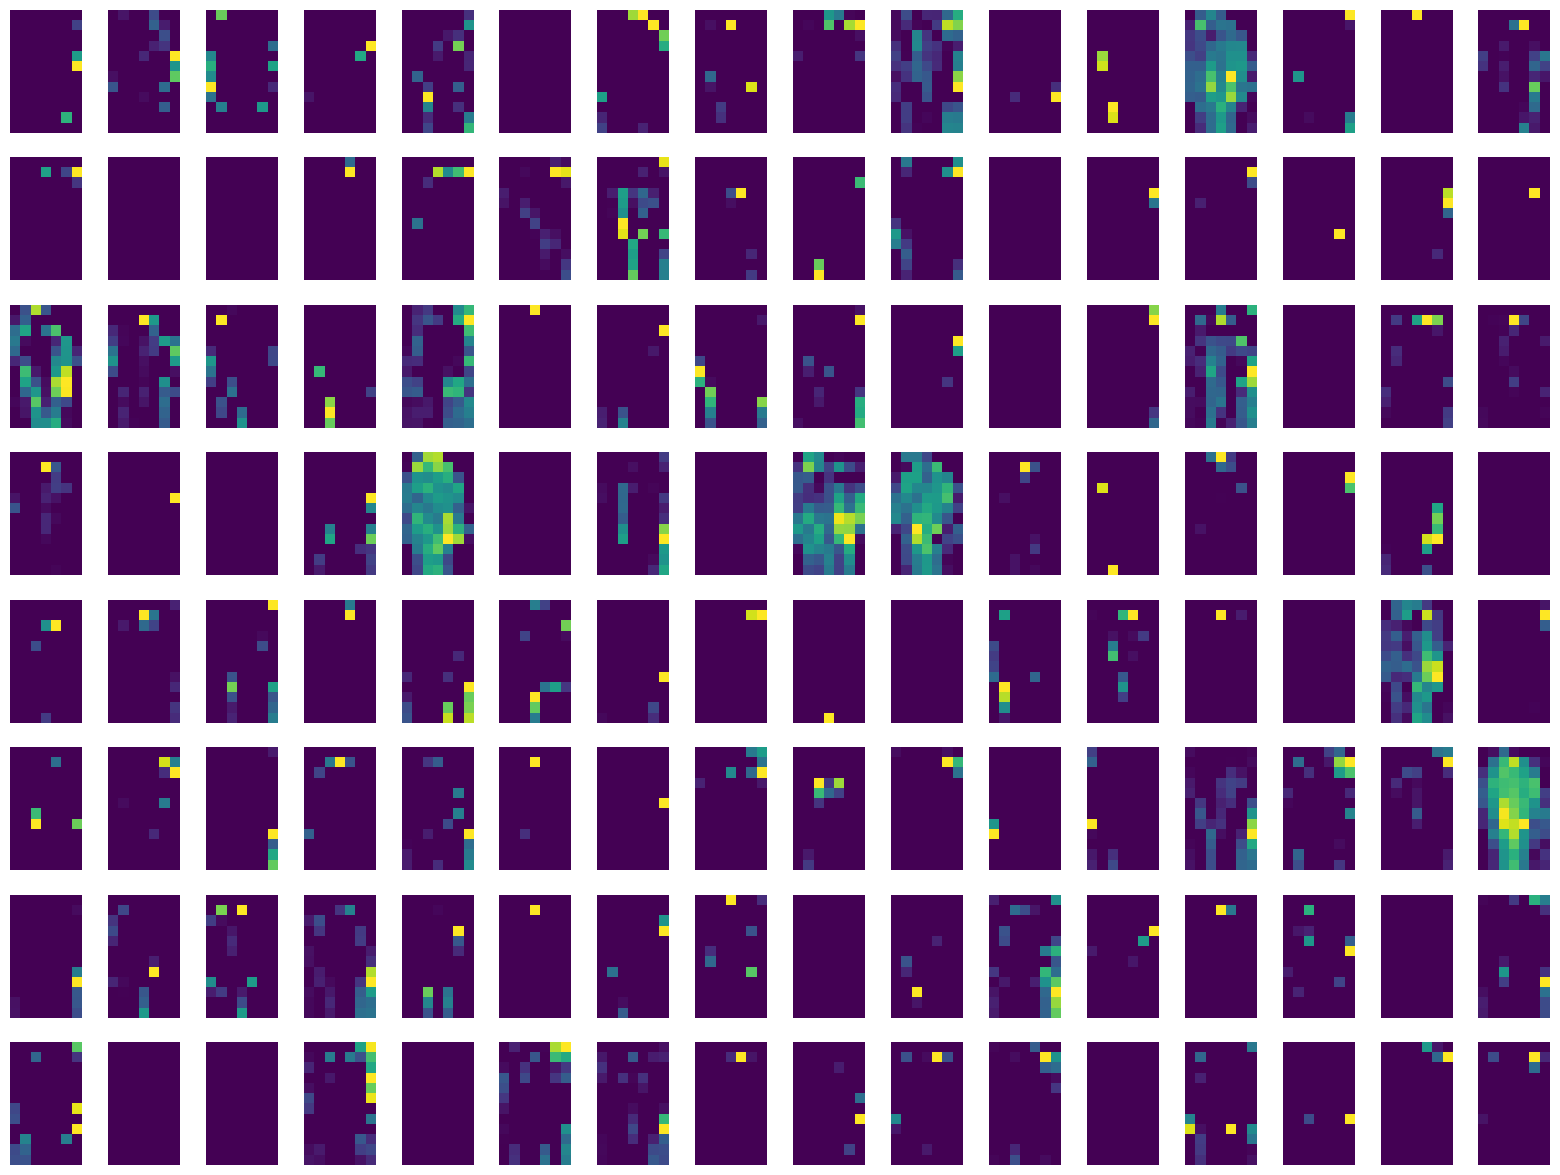

In [18]:
from tensorflow.keras.models import Model
from numpy import expand_dims
from matplotlib import pyplot

# First conv layer's features maps
img = x_test[0]
img = expand_dims(img, axis = 0)

model1 = Model(inputs=model.inputs , outputs=model.layers[0].output)
features = model1.predict(img)

fig = pyplot.figure(figsize=(20,15))
for i in range(1, features.shape[3]+1):
    pyplot.subplot(4,8,i)
    pyplot.imshow(features[0,:,:,i-1])
    pyplot.axis('off')

# Second conv layer's features maps
model2 = Model(inputs=model.inputs, outputs=model.layers[3].output)
features_1 = model2.predict(img)

fig1 = pyplot.figure(figsize=(20, 15))
for i in range(1, features_1.shape[3] + 1):
    pyplot.subplot(8, 16, i)
    pyplot.imshow(features_1[0, :, :, i - 1], cmap='viridis')
    pyplot.axis('off')

# Third conv layer's features maps
model3 = Model(inputs=model.inputs, outputs=model.layers[6].output)
features_2 = model3.predict(img)

fig2 = pyplot.figure(figsize=(20, 15))
for i in range(1, features_2.shape[3] + 1):
    pyplot.subplot(8, 16, i)  # vì có nhiều feature map hơn
    pyplot.imshow(features_2[0, :, :, i - 1], cmap='viridis')
    pyplot.axis('off')
    
pyplot.show()